In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in "./bean-leaf-lesions-classification" (use force=True to force download)


In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


wczytanie danych

In [ ]:
train_df = pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')
val_df = pd.read_csv('/content/bean-leaf-lesions-classification/val.csv')

train_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + train_df['image:FILE']
val_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + val_df['image:FILE']

train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [ ]:
print(train_df['category'].unique())
print(train_df.shape)
print(val_df.shape)

[0 1 2]
(1034, 2)
(133, 2)


In [ ]:
print(train_df['category'].value_counts())
print(val_df['category'].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64
category
2    45
0    44
1    44
Name: count, dtype: int64


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

Dataset

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, data_frame, transform=None):
    self.data_frame = data_frame
    self.transform = transform
    self.labels = torch.tensor(data_frame['category']).to(device)

  def __len__(self):
    return self.data_frame.shape[0]

  def __getitem__(self, idx):
    img_path = self.data_frame.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path)

    if self.transform:
      image = (self.transform(image)/255.0).to(device) #normalizacja poniewaz ma dane od 0 - 255

    return image, label




In [ ]:
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)

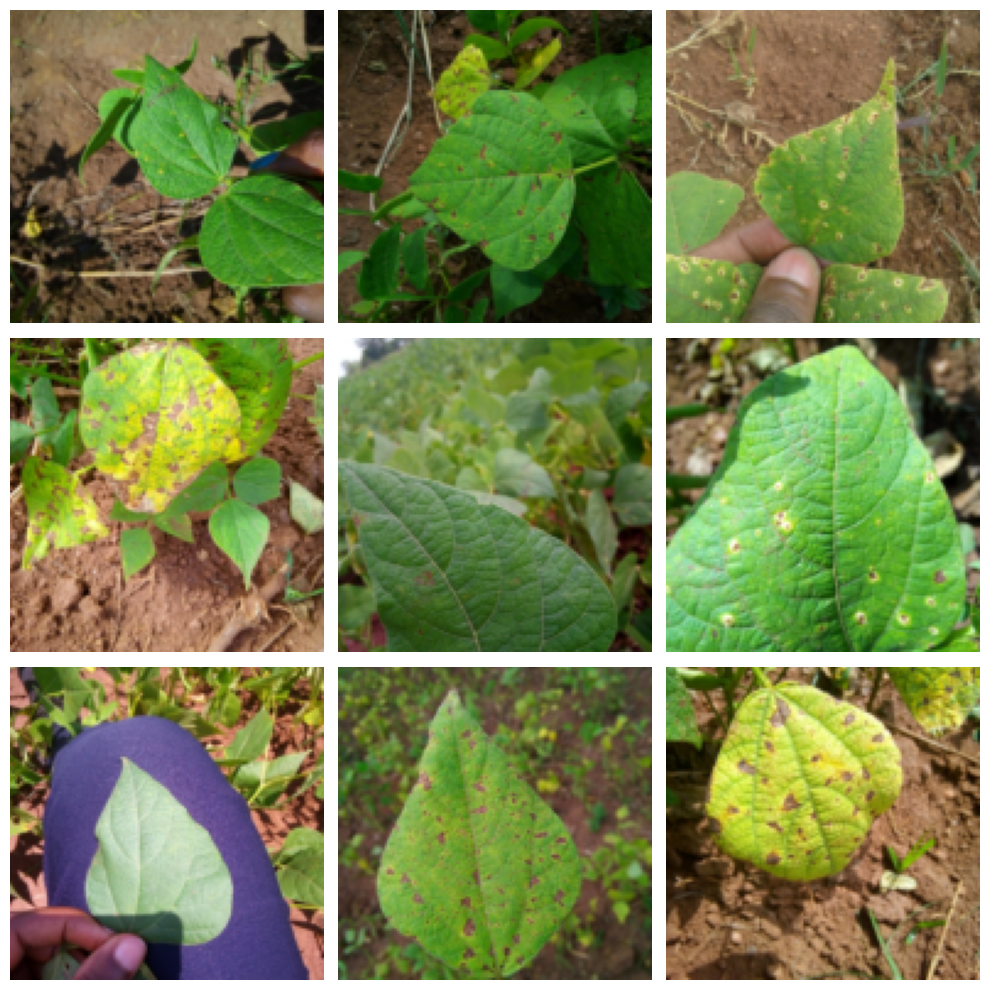

In [ ]:
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
    axes[row, col].imshow((image*255).squeeze().permute(1,2,0))
    axes[row, col].axis('off')


plt.tight_layout()
plt.show()

hiper parametry

In [ ]:
LR = 1e-3
BATCH_SIZE = 8
EPOCHS = 15

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False)

# GOOGLENET

użycie gotowego modelu googlenet

In [ ]:
googlenet_model = models.googlenet(weights='DEFAULT')

In [ ]:
for param in googlenet_model.parameters():
  param.requires_grad = True # chcemy, żeby cały model był trenowalny czyli uczy się od nowa, false zamraza czesc wag

sprawdzamy ostatnią warstwe

In [ ]:
googlenet_model.fc #na wyjsciu ma 1000 klas natomiast my potrzebujemy tylko 3

Linear(in_features=1024, out_features=1000, bias=True)

zmieniamy ostatni parametr

In [ ]:
num_classes = len(train_df['category'].unique())
print(num_classes)

googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

3


Linear(in_features=1024, out_features=3, bias=True)

przenosimy model do gpu

In [ ]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

In [ ]:
total_loss_train_plot = [] #strata
total_acc_train_plot = [] #dokładność


# Główna pętla treningowa – iteracja po epokach
for epoch in range(EPOCHS):
  # Zerowanie sumatorów dla danej epoki
  total_loss_train = 0.0
  total_acc_train = 0.0
  total_loss_val = 0.0
  total_acc_val = 0.0

  # Pętla po batchach treningowych
  for inputs, labels in train_loader:
    optimizer.zero_grad()  # Zerowanie gradientów przed każdą aktualizacją

    outputs = googlenet_model(inputs)  # Przekazanie danych przez model (forward pass)

    train_loss = criterion(outputs, labels)  # Obliczenie straty
    total_loss_train += train_loss.item()    # Dodanie wartości straty (float) do sumy

    train_loss.backward()  # Propagacja wsteczna – obliczenie gradientów

    # Obliczenie liczby poprawnie sklasyfikowanych próbek
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()  # Aktualizacja wag modelu na podstawie gradientów

    #rysowanie wykresów normalizacja ogromnych liczb przez 1000

  fin_total_loss_train = round(total_loss_train /1000, 4)
  fin_total_acc_train = round(total_acc_train /train_dataset.__len__() * 100, 4)



  total_loss_train_plot.append(fin_total_loss_train)
  total_acc_train_plot.append(fin_total_acc_train)

  print(f'''Epoch no. {epoch + 1}/{EPOCHS} Train Loss: {fin_total_loss_train} Train Accuracy: {fin_total_acc_train}''')
  print("="*25)

Epoch no. 1/15 Train Loss: 0.1041 Train Accuracy: 65.3772
Epoch no. 2/15 Train Loss: 0.0913 Train Accuracy: 68.3752
Epoch no. 3/15 Train Loss: 0.0758 Train Accuracy: 75.0484
Epoch no. 4/15 Train Loss: 0.0736 Train Accuracy: 76.7892
Epoch no. 5/15 Train Loss: 0.0707 Train Accuracy: 78.0464
Epoch no. 6/15 Train Loss: 0.0617 Train Accuracy: 81.7215
Epoch no. 7/15 Train Loss: 0.0569 Train Accuracy: 83.7524
Epoch no. 8/15 Train Loss: 0.0549 Train Accuracy: 83.3656
Epoch no. 9/15 Train Loss: 0.056 Train Accuracy: 83.3656
Epoch no. 10/15 Train Loss: 0.0523 Train Accuracy: 85.9768
Epoch no. 11/15 Train Loss: 0.0478 Train Accuracy: 85.7834
Epoch no. 12/15 Train Loss: 0.0388 Train Accuracy: 88.2979
Epoch no. 13/15 Train Loss: 0.046 Train Accuracy: 88.1044
Epoch no. 14/15 Train Loss: 0.037 Train Accuracy: 87.7176
Epoch no. 15/15 Train Loss: 0.0337 Train Accuracy: 90.7157


testowanie

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(val_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/val_dataset.__len__())*100, 2)}%")

Accuracy Score is: 45.86%


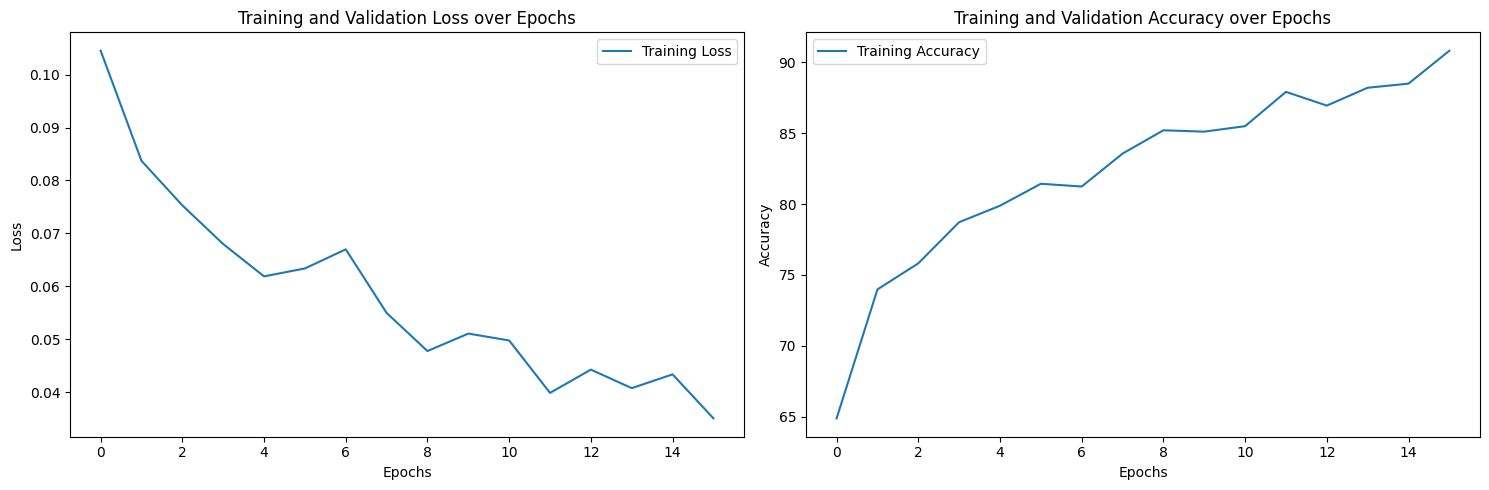

In [ ]:
ig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
#axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
#axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()